本教程介绍UniParser Tools的高阶用法。

本文以 30001 端口提供的UniParser服务为例进行演示。

该端口服务提供最新Parser能力支持，可以提取
- 图片+图题+图注
- 表格+表题+表注
- 分子+分子索引
- 公式+公式索引

## 导入依赖

In [1]:
import json
import os

from IPython.display import HTML, Latex, Markdown, display

from uniparser_tools.api.clients import UniParserClient
from uniparser_tools.common.constant import FormatFlag, ParseMode, ParseModeTextual
from uniparser_tools.utils.convert import dict2obj
from uniparser_tools.utils.processor import tree_repr


## 初始化

In [2]:
# 目前有多个可用host开启，但是不同host对应功能不完全相同，解析质量也不一样
# 具体请在售后群中咨询相关的的host信息和功能
# 使用时请勿并发数量过大，公开Uni-Parser服务最高仅允许5并发

UNIPARSER_PRIVATE_IP = os.getenv('UNIPARSER_PRIVATE_IP')
host = f"http://{UNIPARSER_PRIVATE_IP}:30001"  # 火山云内网
# host = f"http://{UNIPARSER_PUBLIC_IP}:30001"  # 外网

# 替换为你的用户名, 目前不需要认证，只是一个标识，后续需要填写api key等认证信息
user = "advance"  # 用于生成token，务必修改，使用默认user可能会与其他用户导致任务重复

# 初始化客户端
parser = UniParserClient(user=user, host=host)

# 创建一个目录来保存解析结果
save_dir = "./outputs/advance"
os.makedirs(save_dir, exist_ok=True)

## 解析文件

In [3]:
# 设置解析文件路径
pdf_path = "./tasks/He_Deep_Residual_Learning_CVPR_2016_paper.pdf"

# 提交解析任务
trigger_file_result = parser.trigger_file(
    pdf_path,
    textual=ParseModeTextual.DigitalExported,
    table=ParseMode.OCRFast,
    molecule=ParseMode.OCRFast,
    chart=ParseMode.DumpBase64,
    figure=ParseMode.DumpBase64,
    expression=ParseMode.DumpBase64,
    equation=ParseMode.OCRFast,
)
if trigger_file_result["status"] != "success":
    print(json.dumps(trigger_file_result, indent=4))
    raise Exception("trigger file failed")
print(f"trigger file success, token is: {trigger_file_result['token']}")

trigger file success, token is: e447e0be87265d3aba82fcf1aabb6384


## 获取结果
> 可以持有token多次进行获取

In [4]:
assert trigger_file_result["status"] == "success"
token = trigger_file_result["token"]
# token = "e4d85a146b4554c8b23a9753232253cf"
formatted = FormatFlag.Plain  # formatted 只对objects和content产生作用，pages_dict和pages_tree不受影响
result = parser.get_formatted(
    token,
    content=False,
    objects=False,
    pages_dict=False,
    pages_tree=True,
    molecule_source=False,
    textual=formatted,
    chart=formatted,
    table=formatted,
    molecule=formatted,
    equation=formatted,
    figure=formatted,
    expression=formatted,
)
if result["status"] != "success":
    print(f"Get formatted failed for {formatted}, results is: {json.dumps(result, indent=4)}")


### 1. 重建文档结构树

In [5]:
pages_tree = dict2obj(result["pages_tree"]) 

### 2. 查看文档结构树
> 服务更新或升级可能会导致后文代码需要做细微调整

In [6]:
pages_tree[0]

[TextualResult(token='e447e0be87265d3aba82fcf1aabb6384', page=0, block=14, bbox=BBox(x1=0.24928193933823528, y1=0.1339111328125, x2=0.7216222426470589, y2=0.1522216796875), conf=0.88818359375, page_size=[1224, 1584], type='documenttitle', hidden=False, order=0, lang='en', direction=<Direction.Normal: -1>, source='', bboxes=[], contents=[], text='Deep Residual Learning for Image Recognition'),
 TextualResult(token='e447e0be87265d3aba82fcf1aabb6384', page=0, block=19, bbox=BBox(x1=0.22163660386029413, y1=0.1917724609375, x2=0.7538488051470589, y2=0.2474365234375), conf=0.533203125, page_size=[1224, 1584], type='paragraph', hidden=False, order=1, lang='en', direction=<Direction.Normal: -1>, source='', bboxes=[], contents=[], text='Kaiming He Xiangyu Zhang Shaoqing Ren Jian Sun Microsoft Research {kahe, v-xiangz, v-shren, jiansun}@microsoft.com'),
 TextualResult(token='e447e0be87265d3aba82fcf1aabb6384', page=0, block=17, bbox=BBox(x1=0.23743393841911764, y1=0.284912109375, x2=0.31199735753

### 3. 展示全文

# Deep Residual Learning for Image Recognition


Kaiming He Xiangyu Zhang Shaoqing Ren Jian Sun Microsoft Research {kahe, v-xiangz, v-shren, jiansun}@microsoft.com


# Abstract


Deeper neural networks are more difﬁcult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. We explicitly reformulate the layers as learn- ing residual functions with reference to the layer inputs, in- stead of learning unreferenced functions. We provide com- prehensive empirical evidence showing that these residual networks are easier to optimize, and can gain accuracy from considerably increased depth. On the ImageNet dataset we evaluate residual nets with a depth of up to 152 layers—8× deeper than VGG nets [40] but still having lower complex- ity. An ensemble of these residual nets achieves 3.57% error on the ImageNet test set. This result won the 1st place on the ILSVRC 2015 classiﬁcation task. We also present analysis on CIFAR-10 with 100 and 1000 layers.


The depth of representations is of central importance for many visual recognition tasks. Solely due to our ex- tremely deep representations, we obtain a 28% relative im- provement on the COCO object detection dataset. Deep residual nets are foundations of our submissions to ILSVRC & COCO 2015 competitions1, where we also won the 1st places on the tasks of ImageNet detection, ImageNet local- ization, COCO detection, and COCO segmentation.


# 1. Introduction


Deep convolutional neural networks [22, 21] have led to a series of breakthroughs for image classiﬁcation [21, 49, 39]. Deep networks naturally integrate low/mid/high- level features [49] and classiﬁers in an end-to-end multi- layer fashion, and the “levels” of features can be enriched by the number of stacked layers (depth). Recent evidence [40, 43] reveals that network depth is of crucial importance, and the leading results [40, 43, 12, 16] on the challenging ImageNet dataset [35] all exploit “very deep” [40] models, with a depth of sixteen [40] to thirty [16]. Many other non- trivial visual recognition tasks [7, 11, 6, 32, 27] have also




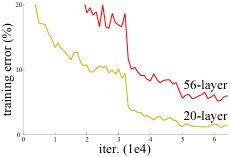

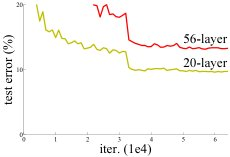

Figure 1. Training error (left) and test error (right) on CIFAR-10 with 20-layer and 56-layer “plain” networks. The deeper network has higher training error, and thus test error. Similar phenomena on ImageNet is presented in Fig. 4.


greatly beneﬁted from very deep models.


Driven by the signiﬁcance of depth, a question arises: Is learning better networks as easy as stacking more layers? An obstacle to answering this question was the notorious problem of vanishing/exploding gradients [14, 1, 8], which hamper convergence from the beginning. This problem, however, has been largely addressed by normalized initial- ization [23, 8, 36, 12] and intermediate normalization layers [16], which enable networks with tens of layers to start con- verging for stochastic gradient descent (SGD) with back- propagation [22].


When deeper networks are able to start converging, a degradation problem has been exposed: with the network depth increasing, accuracy gets saturated (which might be unsurprising) and then degrades rapidly. Unexpectedly, such degradation is not caused by overﬁtting, and adding more layers to a suitably deep model leads to higher train- ing error, as reported in [10, 41] and thoroughly veriﬁed by our experiments. Fig. 1 shows a typical example.


The degradation (of training accuracy) indicates that not all systems are similarly easy to optimize. Let us consider a shallower architecture and its deeper counterpart that adds more layers onto it. There exists a solution by construction to the deeper model: the added layers are identity mapping, and the other layers are copied from the learned shallower model. The existence of this constructed solution indicates that a deeper model should produce no higher training error than its shallower counterpart. But experiments show that our current solvers on hand are unable to ﬁnd solutions that


CyF -


This CVPR paper is the Open Access version, provided by the Computer Vision Foundation. Except for this watermark, it is identical to the version available on IEEE Xplore.


1http://image-net.org/challenges/LSVRC/2015/ and http://mscoco.org/dataset/#detections-challenge2015.


1770


In [7]:
display(Markdown("\n\n".join([item.format_as(FormatFlag.Markdown) for item in pages_tree[0]])))

#### - 展示图文对

In [8]:
img_cap_group = pages_tree[0][8]

In [9]:
print(tree_repr(img_cap_group))

group
├─ image
│  ├─ chart
│  └─ chart
└─ imagecaption




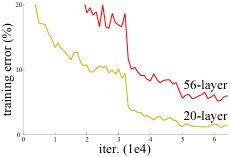

In [10]:
one_fig = img_cap_group.items[0].items[0]

display(HTML(f'<img src="data:image/png;base64,{one_fig.source}" />'))


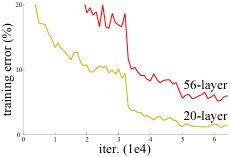

In [11]:
display(HTML(one_fig.format_as(FormatFlag.Html)))


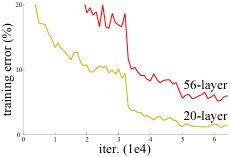
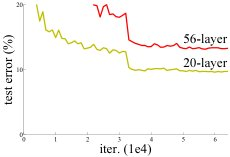

In [12]:
display(HTML(img_cap_group.format_as(FormatFlag.Html)))

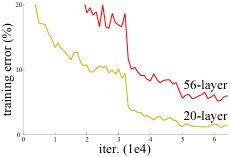

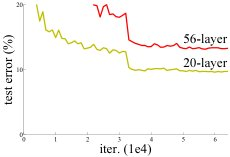

Figure 1. Training error (left) and test error (right) on CIFAR-10 with 20-layer and 56-layer “plain” networks. The deeper network has higher training error, and thus test error. Similar phenomena on ImageNet is presented in Fig. 4.


In [13]:
display(Markdown(img_cap_group.format_as(FormatFlag.Markdown)))

In [14]:
# LaTeX 不支持 base64 图片，理论上支持图片文件，但目前未测试
display(Latex(img_cap_group.format_as(FormatFlag.Latex)))

<IPython.core.display.Latex object>

#### - 展示公式

In [15]:
math_group = pages_tree[2][14]

In [16]:
print(tree_repr(math_group))

group
├─ equation
└─ equationid



In [17]:
display(Markdown(math_group.format_as(FormatFlag.Markdown)))

$$
\mathbf{y}=\mathcal{F}(\mathbf{x},\{W_{i}\})+W_{s}\mathbf{x}.
$$

(2)


#### - 展示表格

In [18]:
table_group = pages_tree[5][0]

In [19]:
print(tree_repr(table_group))

group
├─ table
└─ tablecaption



In [20]:
display(Markdown(table_group.format_as(FormatFlag.Markdown)))

| model          | top-1 err.   | top-5 err.   |
|:---------------|:-------------|:-------------|
| VGG-16 [40]    | 28.07        | 9.33         |
| GoogLeNet [43] | -            | 9.15         |
| PReLU-net [12] | 24.27        | 7.38         |
| plain-34       | 28.54        | 10.02        |
| ResNet-34 A    | 25.03        | 7.76         |
| ResNet-34 B    | 24.52        | 7.46         |
| ResNet-34 C    | 24.19        | 7.40         |
| ResNet-50      | 22.85        | 6.71         |
| ResNet-101     | 21.75        | 6.05         |
| ResNet-152     | 21.43        | 5.71         |

Table 3. Error rates (%, 10-crop testing) on ImageNet validation. VGG-16 is based on our test. ResNet-50/101/152 are of option B that only uses projections for increasing dimensions.


### 4. 输出到文件

In [21]:
with open(f"{save_dir}/page_5.md", "w") as f:
    f.write("\n\n".join([item.format_as(FormatFlag.Markdown) for item in pages_tree[5]]))